In [1]:
from config import config
import skimage
import pickle
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torch.utils.data import Dataset, DataLoader
import copy
import time
from sklearn.manifold import TSNE
from data_handling import unpickle
from image_feature_extraction import load_images, reshape_images, even_instances
from cnn_codes import retrieve_cnn_codes

In [2]:
#load the data 
#this process can be automated since I am also using it in a different file - #TODO
path_to_restrained_dataset = config['paths']['restricted_dataset_path']
train_data, train_labels, test_data, test_labels = load_images(path_to_restrained_dataset)
# make sure every class has the same number of instances
train_data, train_labels = even_instances(train_data, train_labels, limit=500)

print("The shape of train data: ", train_data.shape)
n_channels =3
#length of width and height of each image
size_image = 32
train_data = reshape_images(train_data, size_image, n_channels)


The shape of train data:  (5000, 3072)


### Convert the initial dataset to the format acceptably by Pytorch

In [3]:
#introdcing the data
#normalization values taken from this thread: https://github.com/kuangliu/pytorch-cifar/issues/19
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                             (0.247, 0.243, 0.261))
        
    ])

class restrictedCIFAR10(Dataset):
    def __init__(self, data, transform=transform):

        self.data = data
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        image = self.data[idx,:]
        sample = image

        if self.transform:
            sample = self.transform(image.astype(np.uint8))

        return sample

tensor_dataset = restrictedCIFAR10(train_data, transform)


In [4]:
dataLoader = DataLoader(tensor_dataset, batch_size=1, num_workers=3)

## Pre-trained network
In this part of the assignment, I will be using the pre-trained network VGG-19. Below, there is a representation of its structure. The steps of proceeding are as follows:
- first load a pre-trained VGG-19 network
- remove the last layer which is usually used for classification
- pass the images through the pre-trained network to obtain their feature representation

Unfortunately, this notebook is barely working and cannot even load the pre-trained model without timeout issues. Thus, the code is transferred to python file called "cnn_codes.py". The resulting representation of the training set and the test set is saved in a serialized format for later proceedings (visualizations etc.). 

In [5]:
#initialize the pre-trained model
model_vgg19 = models.vgg19(pretrained=True)

In [6]:
print("The structure of VGG-19 network: ")
print(model_vgg19)

The structure of VGG-19 network: 
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [7]:
#deleting the last layer for classification
model_vgg19.classifier = model_vgg19.classifier[:-1]
print(model_vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [10]:
#now I have to obtain the prediction for each image in the dataset



In [10]:
for params in model_vgg19.parameters():
    params.requires_grad = False

cnn_codes_final = retrieve_cnn_codes(dataLoader, model_vgg19, )
# cnn_codes_inception = retrieve_cnn_codes(dataLoader, model_inception3_restricted)
#then I have to downgrade the dimensionality to 2 and plot them 

0  completed in 0.022899150848388672
100  completed in 1.5149271488189697
200  completed in 87.10264205932617
300  completed in 179.84032797813416
400  completed in 280.63469195365906
500  completed in 384.18887209892273
600  completed in 489.10327100753784
700  completed in 594.4060280323029
800  completed in 700.2561349868774
900  completed in 806.4376850128174
1000  completed in 911.7928910255432
1100  completed in 1017.9277491569519
1200  completed in 1124.1144211292267
1300  completed in 1231.3466420173645
1400  completed in 1341.301295042038
1500  completed in 1463.0815279483795
1600  completed in 1568.0905771255493
1700  completed in 1679.5088810920715
1800  completed in 1783.9210629463196
1900  completed in 1886.971704006195
2000  completed in 1991.836147069931
2100  completed in 2098.9993040561676
2200  completed in 2206.1521611213684
2300  completed in 2318.865352153778
2400  completed in 2434.13338303566
2500  completed in 2556.018520116806
2600  completed in 2664.6079130172

In [11]:
cnn_codes_normalized = np.divide(cnn_codes_final-np.mean(cnn_codes_final, axis=0), np.std(cnn_codes_final,axis=0))

In [12]:
#tsne&PCA
from sklearn.decomposition import PCA

def reduce_dimensionality(input_data, n_dim, mode):
    if mode=='tsne':
        reducer = TSNE(n_components=n_dim, random_state=42, verbose=2)
    if mode=='pca':
        reducer = PCA(n_components=n_dim, random_state=42)
    reduced_data = reducer.fit_transform(input_data)
    return reduced_data

In [14]:
pca_reduced = reduce_dimensionality(cnn_codes_final, 2, 'pca')


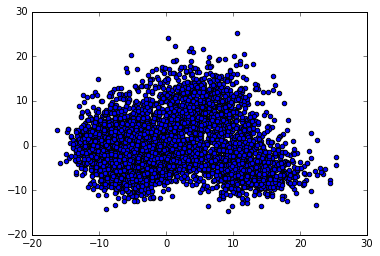

In [15]:
%matplotlib inline
plt.scatter(pca_reduced[:,0], pca_reduced[:,1])

In [ ]:
tsne_reduced = reduce_dimensionality(cnn_codes_final, 2, 'tsne')

In [ ]:
plt.scatter(tsne_reduced[:,0], tsne_reduced[:,1])

In [ ]:
#SVM on top of the extracted CNN codes
#and also perform grid search for the optimal parameters - 
svm = svm.SVC()